In [ ]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

import os

from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl
nCPU= 20
N=4

2025-11-12


In [551]:

# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
#'kremer' # kremer_random'  # gtex_nmd 
title = 'pfib_423'  
# title = 'pmuscle_36'
if title == 'gtex_nmd': # GTEx nmd
    output_path = f'{workdir}/result/dataset_gtex_nmd'
    tissues = pd.read_csv(f'{workdir}/gtex_processed/tissues.tsv', sep='\t', index_col=0)
    # tissues = tissues.query('N_SAMPLE < 150')#.reset_index(drop=True)
    
elif title == 'kremer':
    output_path = f'{workdir}/result/dataset_nc2017kremer'
    datasetdir = f'{workdir}/dataset_nc2017kremer'
    tissues = pd.read_csv(f'{datasetdir}/tissues.tsv', sep='\t', index_col=0)
    
elif title == 'pfib_423':
    output_path = f'{workdir}/result/dataset_pfib_423_split'
    datasetdir = f'{workdir}/pfib_423_processed' 
    use ='split'
    tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
    phase =''
    outlier_sample_col = 'Sample'
    outlier_gene_col = 'Gene'
    
elif title == 'pmuscle_36':
    output_path = f'{workdir}/result/dataset_pmuscle_36'
    datasetdir = f'{workdir}/pmuscle_36_processed' 
    use = 'pmuscle36' # 13k gene min 10 reads
    use = 'pmuscle36_0'
    tissues = pd.read_csv(f'{datasetdir}/tissues_{use}.tsv', sep='\t', index_col=0)
    phase =''
    outlier_sample_col = 'Sample'
    outlier_gene_col = 'Gene' 
else:
    pass
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'
print(samples_path)
tissues.head()

/mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/samples


,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,FBSS,Fibroblast_Stranded,269,12369,/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed...,/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed...
1,FBNS,Fibroblast_NonStranded,154,13411,/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed...,/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed...


,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,M,muscle,36,16700,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...,/mnt/disk7t/xwj/axolotl_rev/pmuscle_36_process...


In [ ]:
zscore = cts.transform(lambda x: (x - x.mean())/x.std(), axis = 1)


In [ ]:
# import sys
# sys.path.append('/media/eys/xwj/axolotl_rev/script')
# 指向函数定义所在的文件路径
# import general# 
from sklearn.metrics import auc
# 遇到的问题 general.pred_outlier_auprc(df_pred, df_outlier)时NameError: name 'auc' is not defined
# 改成直接重定义
def sort_label_score_auprc(res_data, class_col, score_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    返回:
        auprc: AUPRC值
        pr_curve: 用于绘制的PR曲线点
    """
    # 按predict和score排序
    ascend = score_order[score_col]
    sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

    # 创建预测列
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    # 标记真实的异常点
    pr_curve['label'] = 0
    pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1
    
    # 计算precision和recall
    pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

    # 计算AUPRC
    auprc = auc(pr_curve['recall'], pr_curve['precision'])

    # 准备绘图用的曲线点
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
    return auprc, pr_curve.loc[idx]

# def pred_outlier_auprc(df_pred, df_outlier):
    
#     df_pred.index.name = 'Gene'
#     df_pred.columns.name = 'Sample'
#     pr_curve = df_pred.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
#     pr_curve = pr_curve.sort_values(by='pred',ascending=True)
#     pr_curve['label'] = 0
    
#     for i, row in df_outlier.iterrows(): 
#     #     print(i,row['Gene'],row['Sample'])
#         pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
#     pr_curve['rank'] = range(1,pr_curve.shape[0]+1,1)
#     pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
#     pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

#     # auprc value
#     auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
#     # save a simple curve for plotting
#     pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
#     # keep equally distributed points 
#     idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
#     return auprc, pr_curve.loc[idx,]

## 定义函数来计算AUPRC
def pred_outlier_auprc(res_data, df_outlier):
    
    res_data.index.name = 'Gene'
    res_data.columns.name = 'Sample'
    res_data = res_data.T.melt(ignore_index=False,value_name='pred').set_index(['Gene'],append=True).reorder_levels([1, 0])
    sorted_data = res_data.sort_values(by='pred',ascending=True)
    sorted_data['rank'] = range(1, sorted_data.shape[0]+1)
    # 准备PR曲线数据
    pr_curve = sorted_data[['rank']].copy()
    pr_curve['label'] = 0
    
    for i, row in df_outlier.iterrows(): 
    #     print(i,row['Gene'],row['Sample'])
        pr_curve.loc[(row['Gene'], row['Sample']), 'label' ] = 1
    pr_curve['precision'] = (pr_curve['label'].cumsum()/pr_curve['rank']).round(4)
    pr_curve['recall'] = (pr_curve['label'].cumsum()/pr_curve['label'].sum()).round(4)

    # auprc value
    auprc = auc(pr_curve.loc[:,'recall'],pr_curve.loc[:,'precision'])
    
    # save a simple curve for plotting
    pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
    # keep equally distributed points 
    idx = [ (pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg ]
    
    return auprc, pr_curve.loc[idx,]

## precision recall curve add segments for easy plotting
n_seg = 1000
recall_seg = np.linspace(0, 1,num=n_seg+1)

In [383]:
# def myfunc(res_data, class_col, score_col, df_outlier):
#     """
#     计算ABEILLE方法单个打分方式的AUPRC
#     参数:
#         res_data: 包含预测结果的DataFrame
#         score_col: 用于排序的打分列名
#         df_outlier: 包含真实异常的DataFrame
#     返回:
#         auprc: AUPRC值
#         pr_curve: 用于绘制的PR曲线点
#     """
#     # 按predict和score排序
#     ascend = score_order[score_col]
#     sorted_data = res_data.sort_values(by=[ class_col, score_col], ascending=[False, ascend])

#     # 创建预测列
#     sorted_data['rank'] = range(1, sorted_data.shape[0]+1)

#     # 准备PR曲线数据
#     pr_curve = sorted_data[['rank']].copy()
    
#     # 标记真实的异常点
#     pr_curve['label'] = 0
#     print(pr_curve.head())
#     print(pr_curve.loc[('UC51','ENSG00000253293')])
#     pr_curve.loc[ zip(df_outlier['Sample'], df_outlier['Gene']), 'label'] = 1
    
#     # 计算precision和recall
#     pr_curve['precision'] = (pr_curve['label'].cumsum() / pr_curve['rank']).round(4)
#     pr_curve['recall'] = (pr_curve['label'].cumsum() / pr_curve['label'].sum()).round(4)

#     # 计算AUPRC
#     auprc = auc(pr_curve['recall'], pr_curve['precision'])

#     # 准备绘图用的曲线点
#     pr_curve = pr_curve.drop_duplicates(subset=['precision', 'recall'])
#     idx = [(pr_curve['recall'] - seg).abs().idxmin() for seg in recall_seg]
    
#     return auprc, pr_curve.loc[idx]

# myfunc(df_pred, class_col, score, df_outlier)
# list( zip(df_outlier['Sample'], df_outlier['Gene']))
# df_pred

In [358]:


# methods = [ 'OUTRIDER', 'OUTSINGLE', 'MyMethod']
baselines = [ 'OUTRIDER', 'OUTSINGLE', 'ABEILLE' ]
abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'pValue', 'zScore','padjust']
outrider_scores = [ 'padjust']
baselines = [ f'{m}_{score}' for m in ['OUTRIDER', 'ABEILLE'] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ] + ['OUTSINGLE']

mymethods = [ f'f{i}{md}' for i in list(range(20,24)) for md in ['L','I','O']] 
mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] 
             for m in ['L10', 'L20','L30', 'L40'] ]
# mymethods = [ f'{f}{m}' for f in ['f0', 'f0.05','f0.1','f0.2', 'f0.5','f1', 'f2','f4'] for m in [ 'L30', ] ]
mymethods = [ f'{f}{m}' for f in ['f0.1', ] 
             for m in ['L20',] ]
methods = baselines + mymethods
# methods = ['OUTSINGLE', ] + mymethods

num = 49
print(num, phase, recall_seg, methods)

49  [0.    0.001 0.002 ... 0.998 0.999 1.   ] ['OUTRIDER_padjust', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTSINGLE', 'f0.1L20']


In [384]:
# task_config
# outliers_used
# df_pred

In [578]:
%%time
## 20251029 change to save pickle for one tissue & one method
from tqdm import tqdm
# 为兼容以后的子集抽样，需要定义保存不同抽样方案的outlier
dict_outlier_setting = dict()
dict_outlier_setting['all'] = {} 


# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}

for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_res = dict()
    dict_auprc = dict()
    dict_curve = dict()
    
    for k in dict_outlier_setting.keys():
        # --> level 2. (tissue, task) one tissue have many tasks
        if k == 'all':
            prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        else:
            pass # todo, add some change to prefix
        
        # 读入任务
        task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
        samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
        # all outlier
        # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
        # valid split
        outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
        print(prefix, samples.shape, outliers_used.shape)

        if 'Sample' in outliers_used.columns:
            df_outlier = outliers_used
        else:
            outlier_sample_col = 'SAMPLE_ID'
            outlier_gene_col = 'Gene'
            df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})

        
        for m in methods:
            # ==> level 3. (tissue, task, method)
            
            dict_res = dict()
            dict_auprc = dict()
            dict_curve = dict()
            
            for j,row in task_config.iterrows():
                # ==> level 4. (tissue, task, method)
                #----------- 调用函数auprc
                if m.startswith('ABEILLE'):
                    method, score = m.split('_',1)
                    print(method, score)

                    df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                    class_col = 'predict'
                    dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                    
                    # for score in abl_scores:
                    #     print(m,score)
                    #     dict_auprc[f"{m}/{score}"], dict_curve[f"{m}/{score}"] = dict(), dict() 
                    #     dict_auprc[f"{m}/{score}"][j], dict_curve[f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                               
                elif m.startswith('OUTRIDER'):
                    method, score = m.split('_',1)
                    print(method, score)
                    df_pred = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                    class_col = 'aberrant'
                    dict_auprc[j], dict_curve[j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                    # for score in outrider_scores: # score = 'pValue'
                    #     print(m,score)
                    #     dict_auprc[f"{m}/{score}"], dict_curve[f"{m}/{score}"] = dict(), dict() 
                    #     dict_auprc[f"{m}/{score}"][j], dict_curve[f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)  
                           
                elif m == 'OUTSINGLE':
                    print(m)
                    df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                    dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)
                    # dict_auprc[m] ,dict_curve[m] = dict(), dict()
                    # dict_auprc[m][j], dict_curve[m][j] = pred_outlier_auprc(df_pred, df_outlier)
                           
                else: # my method
                    print(m)
                    df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                    dict_auprc[j], dict_curve[j] = pred_outlier_auprc(df_pred, df_outlier)
                    # dict_auprc[m] ,dict_curve[m] = dict(), dict()
                    # dict_auprc[m][j], dict_curve[m][j] = pred_outlier_auprc(df_pred, df_outlier)    
    
            # m is done,
            file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method   
            outputdata = [ t, tn, i, dict_auprc, dict_curve ]
            
            import pickle
            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )


t00_FBSS_s269_g12369 (1, 269) (25, 5)
OUTRIDER padjust


KeyboardInterrupt: 

In [386]:
# 
# df_pred

In [159]:
# dict_auprc[f"{m}/{score}"][j]
# 初始化存储所有数据的DataFrame
dict_curve = dict()
dict_auprc = dict()
all_curves = []
auprc = pd.DataFrame(index=tissues.index, columns=draw_methods)

# 收集所有组织的数据
for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE

    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc[k][m], dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
    # continue
    required_sets = 1
    draw = \
    pd.concat([ 
        pd.concat([(dict_curve[k][m][j]) for j in range(required_sets)],
                axis=0, keys=range(required_sets)).reset_index(drop=True)
        for m in draw_methods], axis=0, keys=draw_methods)\
    .reset_index()
    
    # 添加组织信息
    draw['tissue'] = t
    all_curves.append(draw)
    auprc.loc[i,:] = [dict_auprc['all'][m][0] for m in draw_methods]

# 合并所有组织的数据
all_curves = pd.concat(all_curves)

all_curves.shape

(8008, 7)

In [160]:
# sns.lineplot(data=draw, x="recall", y="precision", hue="level_0", palette='tab10')#, ax= axes[i])
# auprc.loc[i,:] = [ dict_auprc['all'][m][0] for m in draw_methods ]
# dict_auprc
# # dict_curve['all']['OUTRIDER_pValue']

# # pd.concat( [(dict_curve[k][m][j]) for j in range(required_sets) for m in draw_methods ])
# pd.concat([(dict_curve[k][m][j]) for j in range(required_sets)],
#         axis=0, keys=range(required_sets))

# [ 
#         pd.concat([(dict_curve[k][m][j]) for j in range(required_sets)],
#                 axis=0, keys=range(required_sets))
#         for m in draw_methods
# ]
# pd.concat([ 
# pd.concat([(dict_curve[k][m][j]) for j in range(required_sets)],
#         axis=0, keys=range(required_sets)).reset_index(drop=True)
# for m in draw_methods], axis=0, keys=draw_methods)

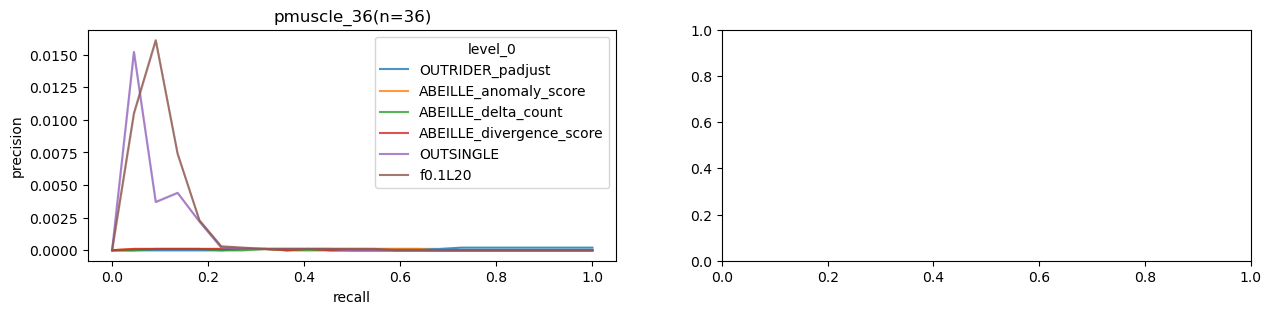

In [389]:
# 非空的元素
draw_methods = methods
plt.style.use('default')
fig, axes = plt.subplots(1, len(tissues.index)+1, figsize=(15, 3))
auprc = pd.DataFrame(index=tissues.index, columns=draw_methods)

for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        file = f'{metric_output_path}/{prefix}_{m}_auprc{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
            # print(tn, m)
        _t, _tn, _i, dict_auprc[k][m], dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
        
    # print(t, tn, i,file)

    required_sets = 1
    draw = \
    pd.concat( [ 
        pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                axis=0, keys= range(required_sets)).reset_index(drop=True)
        for m in draw_methods ], axis=0, keys=draw_methods)\
    .reset_index()
    
    sns.lineplot(data=draw, x="recall", y="precision", hue="level_0", palette='tab10', alpha=0.8, ax= axes[i])
    axes[i].set_title(f'{title}(n={ns})')
    auprc.loc[i,:] = [ dict_auprc['all'][m][0] for m in draw_methods ]

<Axes: >

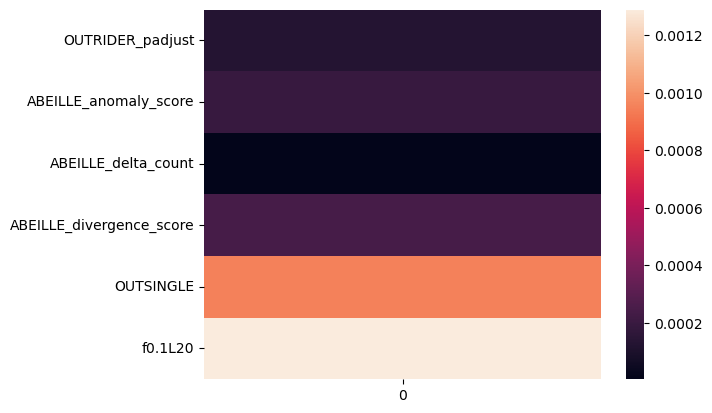

In [180]:
sns.heatmap( auprc.T.astype(np.float32) )
# auprc

## pfib423 split 
1. 抽样方案：全部outlier样本，如 outlier不够，其余用negative填满。 stranded|non-stranded sets. name=FBN S& FBSS. small samplesizes 10~100

In [331]:
import numpy as np
import pandas as pd
from itertools import product

import pickle

# 定义方法和打分方式的对应关系
methods_scores = {
    # 'OUTRIDER': ['aberrant', 'pValue','padjust', 'zScore',],
    'OUTRIDER': ['aberrant', 'padjust',],
    'ABEILLE': ['predict', 'anomaly_score', 'delta_count', 'divergence_score'],
}
outrider_scores = [ 'padjust',]
abl_scores = [ 'anomaly_score', 'delta_count', 'divergence_score']

print(outrider_scores, abl_scores)
# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True
}
rank_types = ['table','sample']
# 创建多级索引，包含样本量和重复信息

n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates)  # 使用0-9作为随机种子

sample_sizes = [ 10, 30,  60, 100, ]# [100, 60, 30, 10]
baselines = [ 'ABEILLE','OUTRIDER', 'OUTSINGLE',] #[  'OUTRIDER', 'OUTSINGLE',]
mymethods = ['f0.1L20']
methods = baselines + mymethods
methods

['padjust'] ['anomaly_score', 'delta_count', 'divergence_score']


['ABEILLE', 'OUTRIDER', 'OUTSINGLE', 'f0.1L20']

In [577]:

use = 'split'
datadir = '/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed/'
tissues = pd.read_csv(f'{datadir}/tissues_{use}.tsv', sep='\t', index_col=0)
# level 1
output_path = f'{workdir}/result/dataset_pfib_423_split'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'
# subsetting file
# 0 FBSS Fibroblast_Stranded (12369, 269) 269
# sampled_configs已保存到: /mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_config/t00_FBSS_s269_g12369_sampled_configs_dict.pkl
# 1 FBNS Fibroblast_NonStranded (13411, 154) 154
# sampled_configs已保存到: /mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_config/t01_FBNS_s154_g13411_sampled_configs_dict.pkl


# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE
    ctsfile = tissue_data['CTS_FILE']  # CTS_FILE
    outlierfile = tissue_data['OUTLIER_FILE']  # OUTLIER_FILE

    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # positive samples
    outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
    assert outlier['Sample'].size == len(set(outlier['Sample']))
    # SS
    output_file = f'{task_config_path}/{name_prefix}_sampled_configs_dict.pkl'
    # name_prefix = 't00_FBSS_s269_g12369'
    # NS
    # output_file = f'{task_config_path}/t01_FBNS_s154_g13411_sampled_configs_dict.pkl'
    # name_prefix = 't01_FBNS_s154_g13411'
    sampled_configs = pickle.load(open(output_file, 'rb'))
    outliers_used = outlier.copy()
    
    for size in sample_sizes:
        
        dict_res = dict() # size
        dict_auprc = dict()
        dict_curve = dict()
        
        for seed in range(n_replicates):
            k = seed
            dict_res[k] = dict() # 10 seeds 
            dict_auprc[k] = dict()
            dict_curve[k] = dict()
            # 获取当前抽样的配置
            current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
            task_config = current_config['config']
            # df_sample = pd.read_csv(task_config['samples'].values[0], index_col='task',sep='\t')
            # samples_used = df_sample.loc[0]
            samples_used = current_config['selected_samples']
            df_outlier = outliers_used.query('(Sample in @samples_used)')
            
            for m in methods:
                # ==> level 3. (tissue, task, method)
                print(size, seed, m)
                dict_res[k][m]= dict()
                for j,row in task_config.iterrows():                    
                    #----------- 调用函数auprc
                    # print(df_outlier.head())
                    
                    if m == 'ABEILLE':
                        
                        df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                        df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                        class_col = 'predict'
                        
                        # samples_used = df_pred['Sample'].unique().tolist()
                        # df_outlier = outliers_used.query('(Sample in @samples_used)')
                        # print(df_outlier.shape, len(samples_used))
            
                        for score in abl_scores:
                            dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                            dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                    
                    elif m == 'OUTRIDER':
                        
                        df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                        df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                        class_col = 'aberrant'
                        # samples_used = df_pred['sampleID'].unique().tolist()
                        # df_outlier = outliers_used.query('(Sample in @samples_used)')
                        # print(df_outlier.shape, len(samples_used))
                        
                        for score in outrider_scores: # score = 'pValue'
                            dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                            dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                    
                    elif m == 'OUTSINGLE':
                        
                        df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                        # samples_used = df_pred.columns.tolist()
                        # df_outlier = outliers_used.query('(Sample in @samples_used)')
                        # print(df_outlier.shape, len(samples_used))
                        
                        dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                        dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)
                        
                    else:
                        df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                        # samples_used = df_pred.columns.tolist()
                        # df_outlier = outliers_used.query('(Sample in @samples_used)')
                        # print(df_outlier.shape, len(samples_used))
                        
                        dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                        dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)                    
                        
                        # df_outlier = outliers_used.query('Sample in @df_pred.columns') 
                                
        file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
        outputdata = [ t, tn, i, dict_auprc, dict_curve ]
        import pickle
        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )

KeyError: 'size_50'

t00_FBSS_s269_g12369
t01_FBNS_s154_g13411


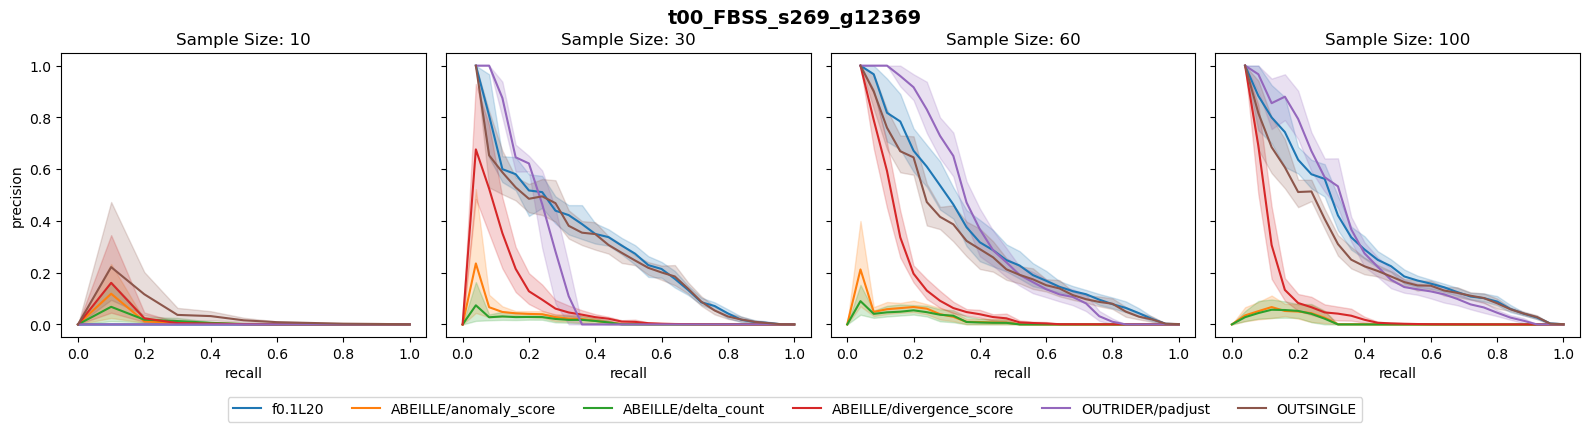

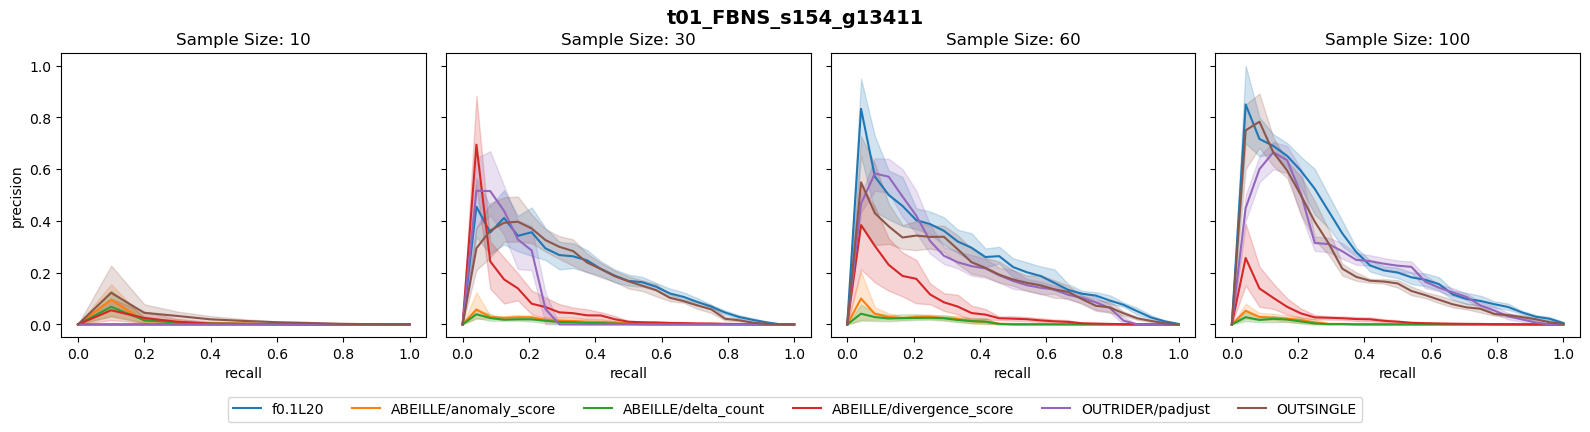

In [332]:
draw_methods = [
    'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
    ]
auprc_data_for_boxplot = dict()
# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    # 创建基础前缀
    name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    print(name_prefix)

    fig, axes = plt.subplots(1, len(sample_sizes), figsize=(4*len(sample_sizes), 4), sharey=True )
    myindex = pd.MultiIndex.from_tuples([ (size, k) for size in sample_sizes for k in range(n_replicates) ],names=['size', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)

    for i, size in enumerate(sample_sizes):
        
        # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl'
        file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
        with open(file,'rb') as f:
            data_load = pickle.load(f)
        _t, _tn, _i, dict_auprc, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
        
        for k in range(n_replicates):
            auprc.loc[(size, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]
            
        required_sets = 1
        draw = \
        pd.concat([
        pd.concat( [ 
            pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                    axis=0, keys= range(required_sets)).drop_duplicates(subset=['label', 'precision', 'recall']).reset_index(drop=True)
            for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
        for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep'])
            
        sns.lineplot(
            data=draw,
            x="recall",
            y="precision",
            hue="method",
            palette='tab10',
            ax=axes[i],
            errorbar=('ci', 95),  # 90%置信区间
            n_boot=100,  # bootstrap采样次数
            alpha=1,
        )
        axes[i].set_title(f'Sample Size: {size}')
            # 1. 去掉子图自己的图例
        axes[i].get_legend().remove()

    # 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5, 0.02),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)

    plt.tight_layout()
    # 给图例留一点底部空间
    fig.subplots_adjust(bottom=0.2)
    fig.suptitle(name_prefix, y=1.02, fontsize=14, fontweight='bold')
    # 保存，用于画 boxplot
    auprc_data_for_boxplot[name_prefix] = auprc


In [272]:
# dict_auprc

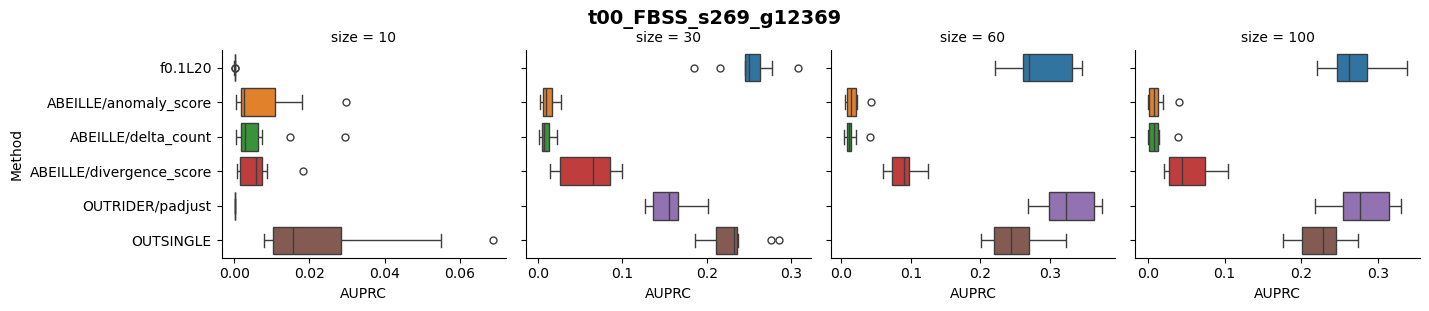

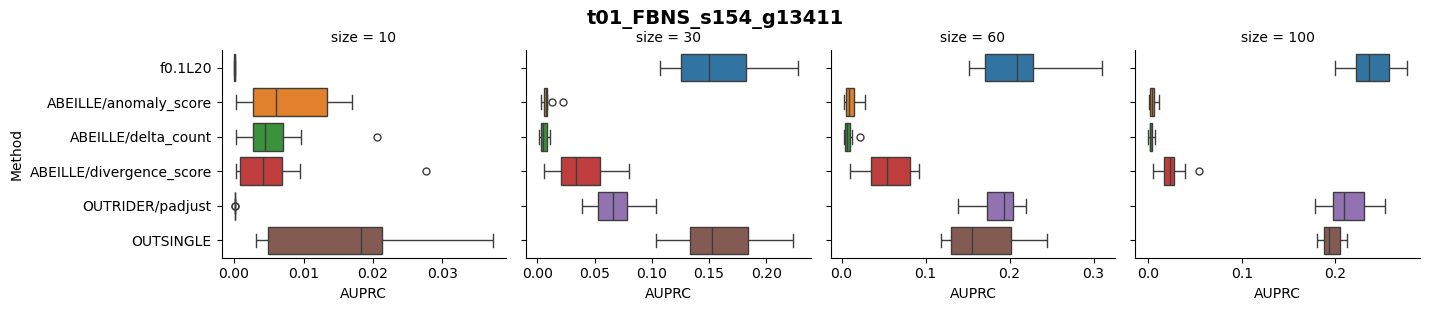

In [277]:
for name_prefix, auprc in auprc_data_for_boxplot.items():
    auprc_long = auprc.stack().reset_index(name='AUPRC').rename(columns={'level_2':'Method'})
    
    g = sns.catplot( auprc_long, kind='box', y = 'Method', x='AUPRC', hue='Method', col='size', 
                orient='h', palette='tab10', sharex=False, height=3, aspect=1.2)
    g.fig.suptitle(name_prefix, y=1.02, fontsize=14, fontweight='bold')
    # # 2. 在每个子图上加标注
    # import itertools
    # pairs = [p for p in itertools.combinations(draw_methods, 2) if 'f0.1L20' in p]

    for ax in g.axes.flat:
        pass
        # ax.set_xscale('log')
    #     annotator = Annotator(
    #         ax, pairs,
    #         data=auprc_long,
    #         x='AUPRC', y='Method',
    #         orient='h'
    #     )
    #     annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    #     annotator.apply_and_annotate()


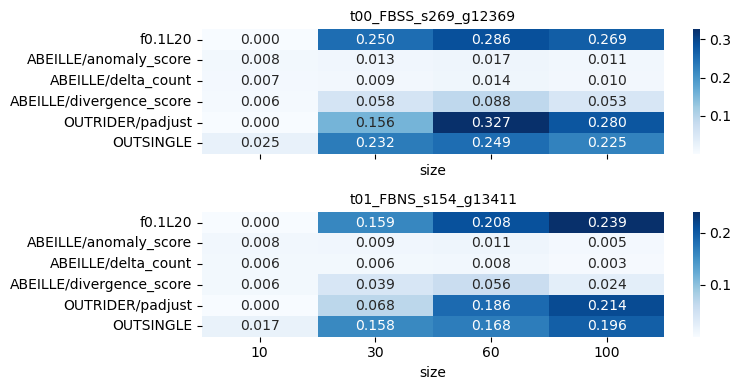

In [340]:
fig, axes = plt.subplots(len(auprc_data_for_boxplot), 1, figsize=(8, 4), sharex=True)

for i, (name_prefix, auprc) in enumerate(auprc_data_for_boxplot.items()):
    sns.heatmap(
        auprc.groupby(level=0).mean().T,
        annot=True,
        cmap='Blues',
        fmt='.3f',
        ax=axes[i]
    )
    axes[i].set_title(name_prefix, fontsize=10)
plt.tight_layout()

## pfib423 split 
1. 抽样方案：指定 percentage of outliers, 必须要大量 negative样本。 stranded|non-stranded sets. name=FBN S& FBSS. small samplesizes 50

In [352]:
import numpy as np
import pandas as pd
from itertools import product

import pickle

# 定义方法和打分方式的对应关系
methods_scores = {
    # 'OUTRIDER': ['aberrant', 'pValue','padjust', 'zScore',],
    'OUTRIDER': ['aberrant', 'padjust',],
    'ABEILLE': ['predict', 'anomaly_score', 'delta_count', 'divergence_score'],
}
outrider_scores = [ 'padjust',]
abl_scores = [ 'anomaly_score', 'delta_count', 'divergence_score']

print(outrider_scores, abl_scores)
# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True
}
rank_types = ['table','sample']
# 创建多级索引，包含样本量和重复信息

n_replicates = 10  # 每个样本量重复10次
random_seeds = range(n_replicates)  # 使用0-9作为随机种子

list_outlier_pct = [ 0.04, 0.08, 0.16, 0.24, 0.32, 0.40 ]
sample_sizes = [50,]

# list_outlier_pct = [ 0.04, 0.08, 0.16, 0.24,]
# sample_sizes = [100,]

baselines = [ 'ABEILLE','OUTRIDER', 'OUTSINGLE',] #[  'OUTRIDER', 'OUTSINGLE',]
mymethods = ['f0.1L20']
methods = baselines + mymethods
methods

['padjust'] ['anomaly_score', 'delta_count', 'divergence_score']


['ABEILLE', 'OUTRIDER', 'OUTSINGLE', 'f0.1L20']

In [346]:
use = 'split'
datadir = '/mnt/disk7t/xwj/axolotl_rev/pfib_423_processed/'
tissues = pd.read_csv(f'{datadir}/tissues_{use}.tsv', sep='\t', index_col=0)
# level 1
output_path = f'{workdir}/result/dataset_pfib_423_split'
# level 2
samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

# subsetting file
# t00_FBSS_s269_g12369_pct0.04
# sampled_configs已保存到: /mnt/disk7t/xwj/axolotl_rev//result/dataset_pfib_423_split/task_config/t00_FBSS_s269_g12369_pct0.04_sampled_configs_dict.pkl

# 从tissues中获取信息
for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE
    ctsfile = tissue_data['CTS_FILE']  # CTS_FILE
    outlierfile = tissue_data['OUTLIER_FILE']  # OUTLIER_FILE
    
    # positive samples
    outlier = pd.read_csv(outlierfile, sep='\t', index_col=0)
    assert outlier['Sample'].size == len(set(outlier['Sample']))
    
    outliers_used = outlier.copy()
    
    for pct in list_outlier_pct: # 增加pct的变化
        # 创建基础前缀
        name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}_pct{pct:.2f}'
        print(name_prefix)
        output_file = f'{task_config_path}/{name_prefix}_sampled_configs_dict.pkl'
        sampled_configs = pickle.load(open(output_file, 'rb'))

        for size in sample_sizes:
            
            dict_res = dict() # size
            dict_auprc = dict()
            dict_curve = dict()
            
            for seed in range(n_replicates):
                k = seed
                dict_res[k] = dict() # 10 seeds 
                dict_auprc[k] = dict()
                dict_curve[k] = dict()
                # 获取当前抽样的配置
                current_config = sampled_configs[f'size_{size}'][f'seed_{seed}']
                task_config = current_config['config']
                # df_sample = pd.read_csv(task_config['samples'].values[0], index_col='task',sep='\t')
                # samples_used = df_sample.loc[0]
                samples_used = current_config['selected_samples']
                df_outlier = outliers_used.query('(Sample in @samples_used)')
                
                for m in methods:
                    # ==> level 3. (tissue, task, method)
                    print(size, seed, m, pct)
                    dict_res[k][m]= dict()
                    for j,row in task_config.iterrows():                    
                        #----------- 调用函数auprc
                        # print(df_outlier.head())
                        
                        if m == 'ABEILLE':
                            
                            df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                            df_pred.index = [(s,g) for s,g in zip(df_pred['Sample'], df_pred['Transcript'])]
                            class_col = 'predict'
                            
                            # samples_used = df_pred['Sample'].unique().tolist()
                            # df_outlier = outliers_used.query('(Sample in @samples_used)')
                            # print(df_outlier.shape, len(samples_used))
                
                            for score in abl_scores:
                                dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                                dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j] = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                        
                        elif m == 'OUTRIDER':
                            
                            df_pred = pd.read_csv(f"{row[m]}_raw.gz", sep='\t',index_col=0)
                            df_pred.index = [(s,g) for s,g in zip(df_pred['sampleID'], df_pred['geneID'])]
                            class_col = 'aberrant'
                            # samples_used = df_pred['sampleID'].unique().tolist()
                            # df_outlier = outliers_used.query('(Sample in @samples_used)')
                            # print(df_outlier.shape, len(samples_used))
                            
                            for score in outrider_scores: # score = 'pValue'
                                dict_auprc[k][f"{m}/{score}"], dict_curve[k][f"{m}/{score}"] = dict(), dict() 
                                dict_auprc[k][f"{m}/{score}"][j], dict_curve[k][f"{m}/{score}"][j]  = sort_label_score_auprc(df_pred, class_col, score, df_outlier)
                        
                        elif m == 'OUTSINGLE':
                            
                            df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                            # samples_used = df_pred.columns.tolist()
                            # df_outlier = outliers_used.query('(Sample in @samples_used)')
                            # print(df_outlier.shape, len(samples_used))
                            
                            dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                            dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)
                            
                        else:
                            df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                            # samples_used = df_pred.columns.tolist()
                            # df_outlier = outliers_used.query('(Sample in @samples_used)')
                            # print(df_outlier.shape, len(samples_used))
                            
                            dict_auprc[k][m] ,dict_curve[k][m] = dict(), dict()
                            dict_auprc[k][m][j], dict_curve[k][m][j] = pred_outlier_auprc(df_pred, df_outlier)                    
                            
                            # df_outlier = outliers_used.query('Sample in @df_pred.columns') 
                                    
            file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
            outputdata = [ t, tn, i, dict_auprc, dict_curve ]
            import pickle
            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )

t00_FBSS_s269_g12369_pct0.04
100 0 ABEILLE 0.04
100 0 OUTRIDER 0.04
100 0 OUTSINGLE 0.04
100 0 f0.1L20 0.04
100 1 ABEILLE 0.04
100 1 OUTRIDER 0.04
100 1 OUTSINGLE 0.04
100 1 f0.1L20 0.04
100 2 ABEILLE 0.04
100 2 OUTRIDER 0.04
100 2 OUTSINGLE 0.04
100 2 f0.1L20 0.04
100 3 ABEILLE 0.04
100 3 OUTRIDER 0.04
100 3 OUTSINGLE 0.04
100 3 f0.1L20 0.04
100 4 ABEILLE 0.04
100 4 OUTRIDER 0.04
100 4 OUTSINGLE 0.04
100 4 f0.1L20 0.04
100 5 ABEILLE 0.04
100 5 OUTRIDER 0.04
100 5 OUTSINGLE 0.04
100 5 f0.1L20 0.04
100 6 ABEILLE 0.04
100 6 OUTRIDER 0.04
100 6 OUTSINGLE 0.04
100 6 f0.1L20 0.04
100 7 ABEILLE 0.04
100 7 OUTRIDER 0.04
100 7 OUTSINGLE 0.04
100 7 f0.1L20 0.04
100 8 ABEILLE 0.04
100 8 OUTRIDER 0.04
100 8 OUTSINGLE 0.04
100 8 f0.1L20 0.04
100 9 ABEILLE 0.04
100 9 OUTRIDER 0.04
100 9 OUTSINGLE 0.04
100 9 f0.1L20 0.04
t00_FBSS_s269_g12369_pct0.08
100 0 ABEILLE 0.08
100 0 OUTRIDER 0.08
100 0 OUTSINGLE 0.08
100 0 f0.1L20 0.08
100 1 ABEILLE 0.08
100 1 OUTRIDER 0.08
100 1 OUTSINGLE 0.08
100 1 f0.1L20

t00_FBSS_s269_g12369_pct0.04
t00_FBSS_s269_g12369_pct0.08
t00_FBSS_s269_g12369_pct0.16
t00_FBSS_s269_g12369_pct0.24
t00_FBSS_s269_g12369_pct0.32
t00_FBSS_s269_g12369_pct0.40
t01_FBNS_s154_g13411_pct0.04
t01_FBNS_s154_g13411_pct0.08
t01_FBNS_s154_g13411_pct0.16
t01_FBNS_s154_g13411_pct0.24
t01_FBNS_s154_g13411_pct0.32
t01_FBNS_s154_g13411_pct0.40


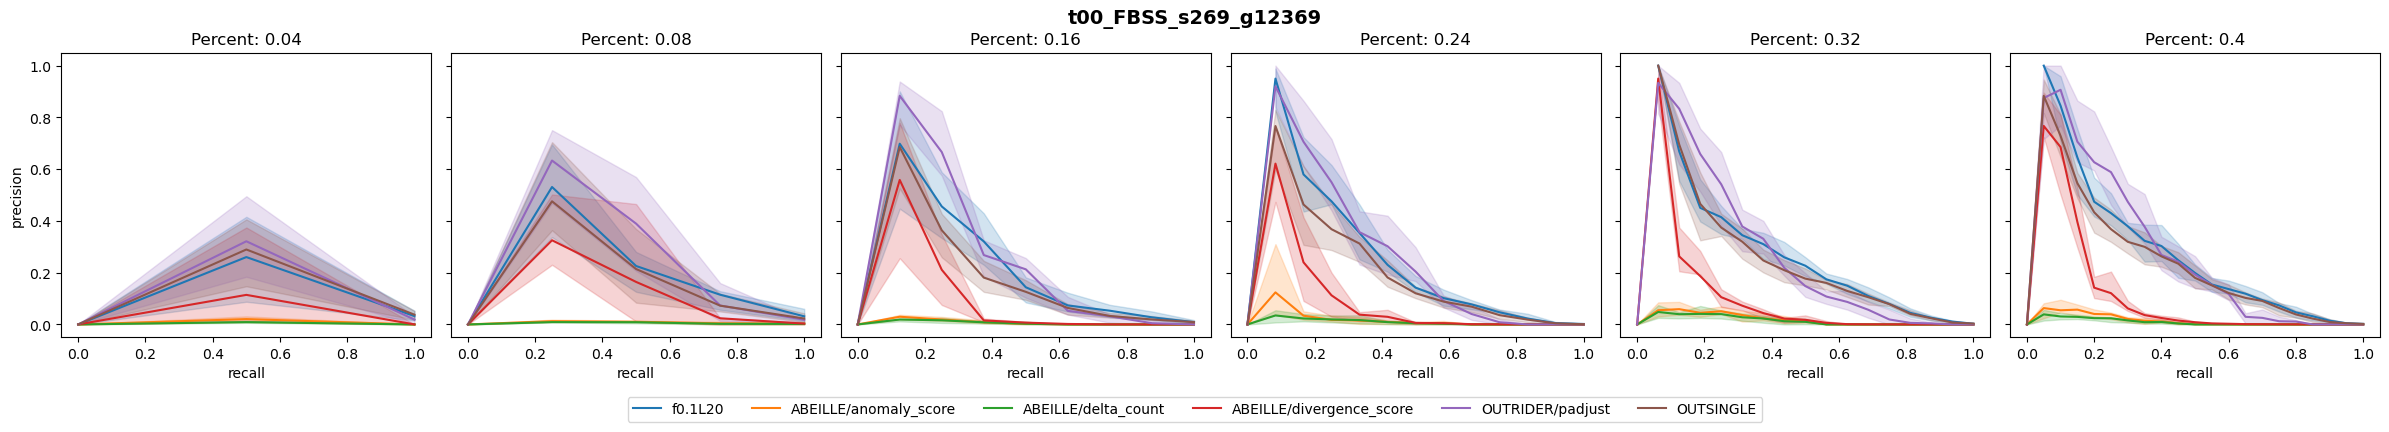

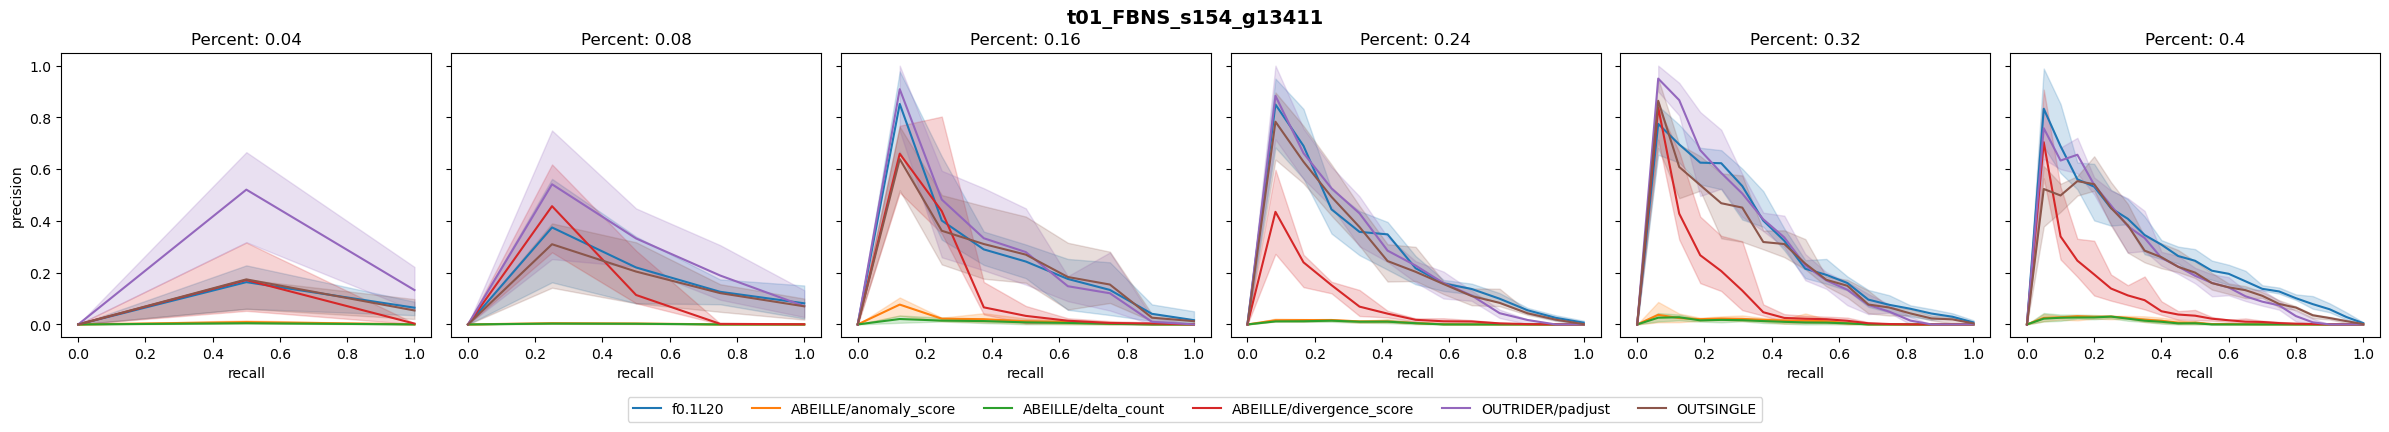

In [353]:
draw_methods = [
    'f0.1L20',
    'ABEILLE/anomaly_score', 
    'ABEILLE/delta_count', 
    'ABEILLE/divergence_score', 
    'OUTRIDER/padjust', 
    'OUTSINGLE'
    ]
auprc_data_for_boxplot = dict()
# 从tissues中获取信息

for i, tissue_data in tissues.iterrows():
    # tissue_data = tissues.iloc[0]
    t = tissue_data['TISSUE_ID']  # TISSUE_ID
    tn = tissue_data['TISSUE_NAME']  # TISSUE_NAME
    ns = tissue_data['N_SAMPLE']  # N_SAMPLE
    ng = tissue_data['N_GENE']  # N_GENE

    fig, axes = plt.subplots(1, len(list_outlier_pct), figsize=(4*len(list_outlier_pct), 4), sharey=True )
    myindex = pd.MultiIndex.from_tuples([ (pct, k) for pct in list_outlier_pct for k in range(n_replicates) ],names=['pct', 'seed'])
    auprc =  pd.DataFrame(index= myindex, columns=draw_methods, dtype=np.float32)
    
    # 创建基础前缀
    for ax_i, pct in enumerate(list_outlier_pct): # 增加pct的变化
        # 创建基础前缀
        name_prefix = f't{i:02d}_{t}_s{ns}_g{ng}_pct{pct:.2f}'
        print(name_prefix)

        for _j, size in enumerate(sample_sizes):
                
            # file = f'{metric_output_path}/t{i:02d}_{t}_auprc.pkl'
            file = f'{metric_output_path}/{name_prefix}_size_{size}_auprc.pkl'
            with open(file,'rb') as f:
                data_load = pickle.load(f)
            _t, _tn, _i, dict_auprc, dict_curve = data_load[0], data_load[1], data_load[2], data_load[3], data_load[4]
            
            for k in range(n_replicates):
                auprc.loc[(pct, k) ,:] = [ dict_auprc[k][m][0] for m in draw_methods ]
                
            required_sets = 1
            draw = \
            pd.concat([
            pd.concat( [ 
                pd.concat( [ (dict_curve[k][m][j]) for j in range(required_sets)],
                        axis=0, keys= range(required_sets)).drop_duplicates(subset=['label', 'precision', 'recall']).reset_index(drop=True)
                for m in draw_methods ], axis=0, keys=draw_methods, names=['method'])
            for k in range(n_replicates)], axis = 0, keys=range(n_replicates),names=['rep'])
                
            sns.lineplot(
                data=draw,
                x="recall",
                y="precision",
                hue="method",
                palette='tab10',
                ax=axes[ax_i],
                errorbar=('ci', 95),  # 90%置信区间
                n_boot=10,  # bootstrap采样次数
                alpha=1,
            )
            axes[ax_i].set_title(f'Percent: {pct}')
                # 1. 去掉子图自己的图例
            axes[ax_i].get_legend().remove()

    # 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels,
            loc='center',           # 居中
            bbox_to_anchor=(0.5, 0.02),  # 放在底部（微调 0.02）
            ncol=len(labels),       # 横向排列
            frameon=True)

    plt.tight_layout()
    # 给图例留一点底部空间
    fig.subplots_adjust(bottom=0.2)
    tissuse_title = f't{i:02d}_{t}_s{ns}_g{ng}'
    fig.suptitle(tissuse_title, y=1.02, fontsize=14, fontweight='bold')
    # 保存，用于画 boxplot
    auprc_data_for_boxplot[tissuse_title] = auprc


In [405]:
# topn recall 
dict_curve[0].query('label == 1').drop_duplicates()

rank  label  precision  recall
Gene   Sample                                  
COL6A1 UC397       95      1     0.0105  0.0455
COL6A2 UC222      124      1     0.0161  0.0909
       UC220      403      1     0.0074  0.1364
COL6A3 UC54      1726      1     0.0023  0.1818
       UC56     17213      1     0.0003  0.2273
       UC129    38528      1     0.0002  0.2727
       UC95     62056      1     0.0001  0.3182
       UC50     70174      1     0.0001  0.3636
COL6A1 UC179   148076      1     0.0001  0.4091
       UC99    148088      1     0.0001  0.4545
COL6A2 UC357   209965      1     0.0001  0.5000
       UC43    239357      1     0.0001  0.5455
       UC264   274783      1     0.0000  0.5909
COL6A3 UC100   338117      1     0.0000  0.6364
COL6A1 UC384   338351      1     0.0000  0.6818
COL6A3 UC21    435280      1     0.0000  0.7273
       UC13    517775      1     0.0000  0.7727
COL6A2 UC51    517807      1     0.0000  0.8182
COL6A1 UC30    517813      1     0.0000  0.8636
       UC98    517823      1     0.0000  0.9091
COL6A2 UC338   517846      1     0.0000  0.9545
COL6A1 UC77    531577      1     0.0000  1.0000

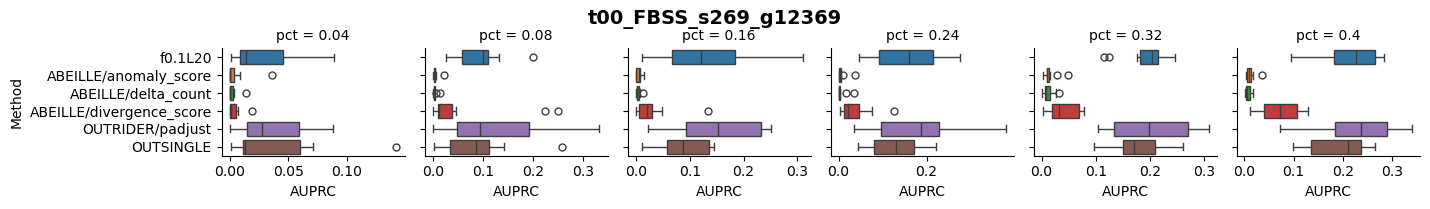

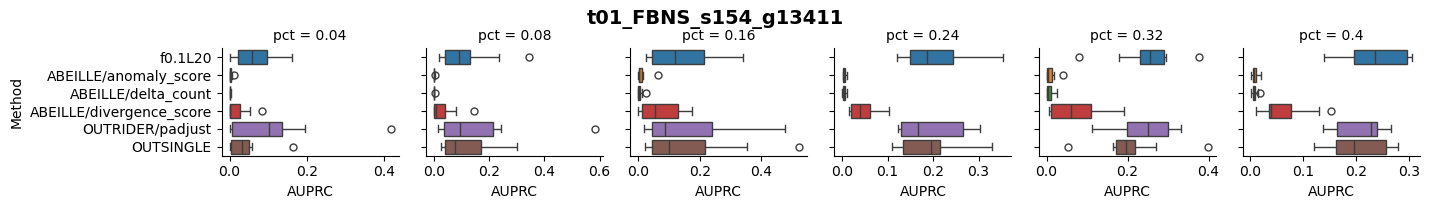

In [355]:
# auprc_data_for_boxplot['t00_FBSS_s269_g12369']
for name_prefix, auprc in auprc_data_for_boxplot.items():
    auprc_long = auprc.stack().reset_index(name='AUPRC').rename(columns={'level_2':'Method'})
    
    g = sns.catplot( auprc_long, kind='box', y = 'Method', x='AUPRC', hue='Method', col='pct', 
                orient='h', palette='tab10', sharex=False, height=2, aspect=1.2)
    g.fig.suptitle(name_prefix, y=1.02, fontsize=14, fontweight='bold')


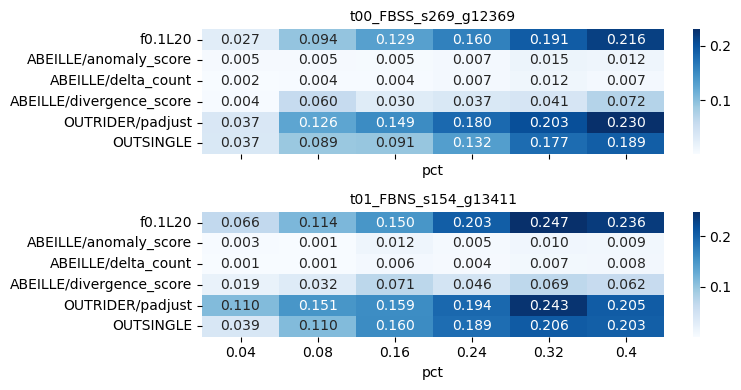

In [356]:
# for name_prefix, auprc in auprc_data_for_boxplot.items():
    
#     fig, axes = plt.subplots(1, 1, figsize=(8, 2), sharey=True )
#     sns.heatmap( auprc.groupby(level=0).mean().T, annot=True, cmap='Blues', fmt='.3f', ax=axes)
#     axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
#     plt.tight_layout()
    
fig, axes = plt.subplots(len(auprc_data_for_boxplot), 1, figsize=(8, 4), sharex=True)

for i, (name_prefix, auprc) in enumerate(auprc_data_for_boxplot.items()):
    sns.heatmap(
        auprc.groupby(level=0).mean().T,
        annot=True,
        cmap='Blues',
        fmt='.3f',
        ax=axes[i]
    )
    axes[i].set_title(name_prefix, fontsize=10)
plt.tight_layout()

['OUTRIDER_padjust',
 'ABEILLE_anomaly_score',
 'ABEILLE_delta_count',
 'ABEILLE_divergence_score',
 'OUTSINGLE',
 'f0.1L20']

In [ ]:
## topn recall

def pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    """
    # 按predict和score排序
    ascend = score_order[ score_col ]
    sorted_data = res_data.pivot_table(columns=sample_col, index=gene_col, values=score_col).rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    df_outlier['rank'] = outlier_rank
    return df_outlier

def sort_score_outlier_rank(res_data, df_outlier, ascend=True):
    sorted_data = res_data.rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    df_outlier['rank'] = outlier_rank
    return df_outlier

methods = ['OUTRIDER_padjust',
 'ABEILLE_anomaly_score',
 'ABEILLE_delta_count',
 'ABEILLE_divergence_score',
 'OUTSINGLE',
 'f0.1L20',
]

from tqdm import tqdm
# 为兼容以后的子集抽样，需要定义保存不同抽样方案的outlier
dict_outlier_setting = dict()
dict_outlier_setting['all'] = {} 

# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}


## 分析一个完整dataset，不带子集抽样
for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_res = dict()
    dict_auprc = dict()
    dict_curve = dict()
    
    for k in dict_outlier_setting.keys():
        # --> level 2. (tissue, task) one tissue have many tasks
        if k == 'all':
            prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        else:
            pass # todo, add some change to prefix
        
        # 读入任务
        task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
        samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
        # all outlier
        # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
        # valid split
        outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
        print(prefix, samples.shape, outliers_used.shape)

        if 'Sample' in outliers_used.columns:
            df_outlier = outliers_used
        else:
            outlier_sample_col = 'SAMPLE_ID'
            outlier_gene_col = 'Gene'
            df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})
        
        for m in methods:
            # ==> level 3. (tissue, task, method)
            dict_res = dict()
            dict_auprc = dict()
            dict_curve = dict()
            
            for j,row in task_config.iterrows():
                # ==> level 4. (tissue, task, method)
                if m.startswith('ABEILLE'):
                    method, score_col = m.split('_',1)
                    print(method, score_col)
                    res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                    class_col = 'predict'
                    gene_col = 'Transcript'
                    sample_col = 'Sample'
                    dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                                                   
                elif m.startswith('OUTRIDER'):
                    method, score_col = m.split('_',1)
                    print(method, score_col)
                    res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                    res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                    class_col = 'aberrant'
                    gene_col = 'geneID'
                    sample_col = 'sampleID'
                    dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)

                elif m == 'OUTSINGLE':
                    print(m)
                    df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                    dict_curve[j] = sort_score_outlier_rank(df_pred, df_outlier)

                else: # my method
                    print(m)
                    df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                    dict_curve[j] = sort_score_outlier_rank(df_pred, df_outlier)

    
            # m is done,
            file = f'{metric_output_path}/{prefix}_{m}_rank{phase}.pkl' # one tissue One method   
            outputdata = [ t, tn, i, dict_curve ]
            
            import pickle
            with open(file, 'wb') as f: 
                pickle.dump( outputdata,  f )


t00_FBSS_s269_g12369 (1, 269) (25, 5)
OUTRIDER padjust
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20
t01_FBNS_s154_g13411 (1, 154) (24, 5)
OUTRIDER padjust
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20


Fibroblast_Stranded OUTRIDER_padjust
Fibroblast_Stranded ABEILLE_anomaly_score
Fibroblast_Stranded ABEILLE_delta_count
Fibroblast_Stranded ABEILLE_divergence_score
Fibroblast_Stranded OUTSINGLE
Fibroblast_Stranded f0.1L20
Fibroblast_NonStranded OUTRIDER_padjust
Fibroblast_NonStranded ABEILLE_anomaly_score
Fibroblast_NonStranded ABEILLE_delta_count
Fibroblast_NonStranded ABEILLE_divergence_score
Fibroblast_NonStranded OUTSINGLE
Fibroblast_NonStranded f0.1L20


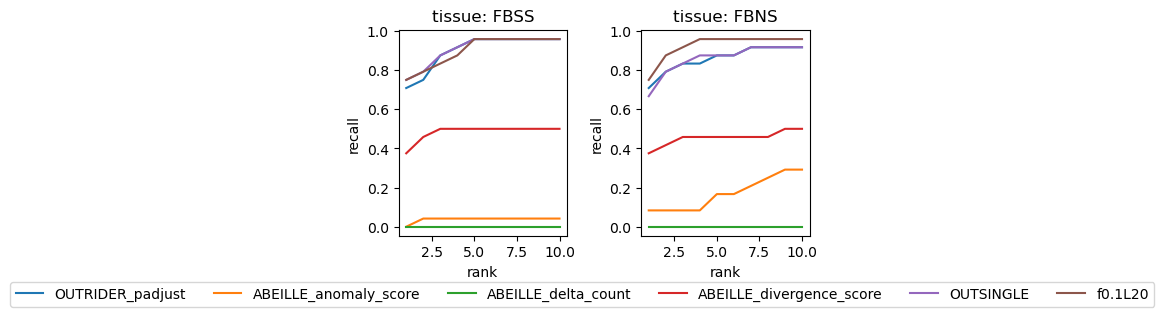

In [575]:
draw_methods = methods
plt.style.use('default')
fig, axes = plt.subplots(1, len(tissues), figsize=(5, 3))
# pd.DataFrame(index=tissues.index, columns=draw_methods)

for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        
        file = f'{metric_output_path}/{prefix}_{m}_rank{phase}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
            print(tn, m)
        _t, _tn, _i, dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3]
        
    # print(t, tn, i,file)

    required_sets = 1
    max_bin = 10
    bins = list(range(0, max_bin + 1)) + [20000]
    nice_names = list(range(1,max_bin + 1))+[20000]#[ f'{x}%' for x in bins[:-1]]
    
    draw = \
    pd.concat( [ 
            pd.concat( [ (dict_curve[k][m][j]['rank'].value_counts(bins= bins, sort=False)) for j in range(required_sets)], axis=0, keys=range(required_sets))
        for m in draw_methods ], axis=0, keys=draw_methods, names=['method']).reset_index()
    
    # sns.lineplot(data=draw, x="recall", y="precision", hue="level_0", palette='tab10', alpha=0.8, ax= axes[i])
    # axes[i].set_title(f'{title}(n={ns})')
    # auprc.loc[i,:] = [ dict_auprc['all'][m][0] for m in draw_methods ]

    draw['rank'] = nice_names * len(draw_methods)
    draw = draw.query('rank < 10000')
    draw['recall'] = draw.groupby('method')['count'].cumsum()/len(df_outlier)

    sns.lineplot(data=draw, x='rank', y="recall", hue="method", palette='tab10', ax=axes[i])
    axes[i].set_title(f'tissue: {t}')
        # 1. 去掉子图自己的图例
    axes[i].get_legend().remove()

# 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels,
        loc='center',           # 居中
        bbox_to_anchor=(0.5, 0),  # 放在底部（微调 0.02）
        ncol=len(labels),       # 横向排列
        frameon=True)
plt.tight_layout()

In [576]:
draw.head()

,method,level_1,level_2,count,rank,recall
0,OUTRIDER_padjust,0,"(-0.001, 1.0]",17,1,0.708333
1,OUTRIDER_padjust,0,"(1.0, 2.0]",2,2,0.791667
2,OUTRIDER_padjust,0,"(2.0, 3.0]",1,3,0.833333
3,OUTRIDER_padjust,0,"(3.0, 4.0]",0,4,0.833333
4,OUTRIDER_padjust,0,"(4.0, 5.0]",1,5,0.875000


In [ ]:
if False:
    ##### rank() -> .cumsum() -> recall plot
    bins = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,50]
    list_ranks = [1,2,3,4,5,6,7,8,9,10,20,30,40,50]
    bins = list(range(0,51))
    list_ranks = list(range(1,51))

    df_eout_rank = pd.DataFrame(
        index= pd.MultiIndex.from_product(
            [ pr_config['Dname'].unique(), list_Z, show, list_ranks ],
            names=['dname','zscore','model','rank']),
        columns=list_simu)

    for (i,x) in pr_config.iterrows():
        if (x['Dname'],Zscore, x['feature_model_code']) in df_eout_rank.index:
            res_in_rows = np.load('%s/%s/z%s_%s_known_eout_rank.pkl' % (x['Outdir'],x['Dname'],Zscore, x['feature_model_code']),allow_pickle=True)
            df_eout_rank.loc[(x['Dname'],Zscore, x['feature_model_code'])]= pd.concat( [ res.value_counts(bins= bins, sort=False).cumsum()/len(res) for res in res_in_rows],axis =1).values

    # df_eout_rank = np.load( file, allow_pickle=True)
    draw = df_eout_rank.stack().reset_index().rename(columns={'level_4':'simu',0:'recall'})
    draw['topN recall'] = draw['recall'].astype(np.float32)
    draw['Dataset'] = [ x.split('_')[0] for x in draw['dname']]
    draw['Nsample'] = [ np.int32(x.split('_')[1]) for x in draw['dname']]
    sns.lineplot(draw, x='rank',y='topN recall',hue='model',ci=None, ax=axes[1])
    # axes.set_ylim(bottom=0,top=1)
    newlabels = [ l.replace('f2m1','AXO') for l in show ]
    axes[1].legend(labels=newlabels)#, bbox_to_anchor =(1,0.5))
    
    